<a href="https://colab.research.google.com/github/Hamza-Ali0237/CIFAR10-Web_App/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Main Libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D

## Loading The Dataset

In [15]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Visualising The Data

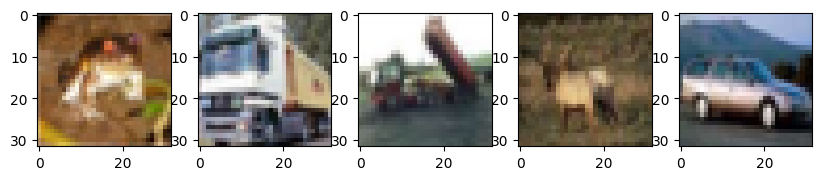

In [16]:
plt.figure(figsize=(10, 10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
plt.show()

### Normalizing the data

In [17]:
X_train, X_test = X_train/255. , X_test/255.

### One-hot Encoding

In [18]:
num_classes = 10

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [19]:
# Display dataset shapes
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## Creating Model (ResNet50)

In [21]:
res_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
    )

x = res_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=res_model.input, outputs=output)

In [22]:
for layer in res_model.layers:
  layer.trainable = False

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          